Albumentations: fast and flexible image augmentations

- [Demo](https://albumentations-demo.herokuapp.com/)
- [Paper](https://arxiv.org/abs/1809.06839)

In [19]:
%reload_ext autoreload
%autoreload 2

import torch
import json
import torchvision
import numpy as np
from models.resnet import ResNet18

import matplotlib.pyplot as plt 

In [2]:
class Config:
    datadir            = '../data/'
    gpu_id             = 0
    lr                 = 0.1
    epochs             = 100
    batch_size         = 128
    accumulation_steps = 1
    num_workers        = 8
    seed               = 223
    # CutMix 
    beta               = 1
    cutmix_prob        = 0.5
    
config = Config()

In [3]:
device = f'cuda:{config.gpu_id}' if torch.cuda.is_available() else 'cpu'

# Load Data

In [4]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root=config.datadir, 
                                         train=True, 
                                         download=True,
                                         transform=transform_train)

testset = torchvision.datasets.CIFAR10(root=config.datadir, 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=config.batch_size, 
                                          shuffle=True, 
                                          num_workers=config.num_workers)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=config.batch_size, 
                                         shuffle=False, 
                                         num_workers=config.num_workers)

Files already downloaded and verified
Files already downloaded and verified


## CutMix Examples

In [6]:
inputs, targets = next(iter(trainloader))

In [7]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [8]:
def cutmix(inputs, targets, beta, device):
    # generate mixed sample
    lam = np.random.beta(config.beta, config.beta)
    rand_index = torch.randperm(inputs.size()[0]).to(device)
    
    targets_a = targets
    targets_b = targets[rand_index]
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    
    return inputs, targets_a, targets_b, lam

In [9]:
temp, targets_a, targets_b, lam = cutmix(inputs, 
                                         targets, 
                                         config.beta, 
                                         device)

In [10]:
temp = np.transpose(inputs.numpy(), axes=[0,2,3,1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


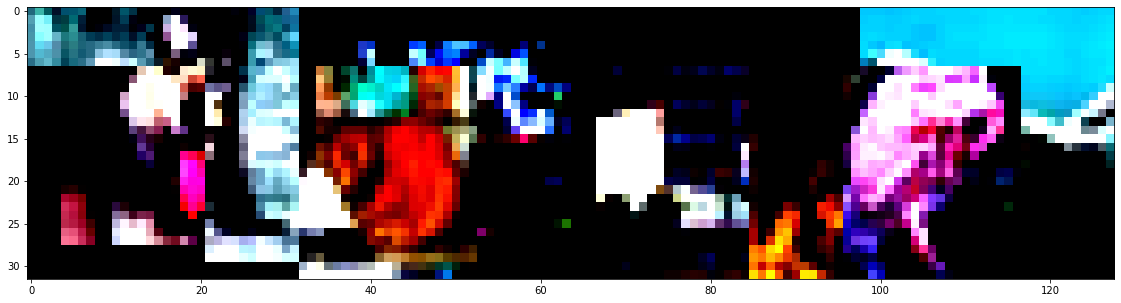

In [11]:
plt.figure(figsize=(20,5))
plt.imshow(np.hstack(temp[:4]))

# Build Model

In [12]:
model = ResNet18().to(device)

# Train

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [14]:
def train(
    model, dataloader, criterion, optimizer, accumulation_steps, beta, cutmix_prob, device='cpu'
):
    correct = 0 
    total = 0
    total_loss = 0
    
    optimizer.zero_grad()
    for idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        
        r = np.random.rand(1)
        if beta > 0 and r < cutmix_prob:
            inputs, targets_a, targets_b, lam = cutmix(inputs,
                                                       targets,
                                                       beta,
                                                       device)
            outputs = model(inputs)
            loss = criterion(outputs, targets_a) * lam + criterion(outputs, targets_b) * (1. - lam)
        else:
            # predict
            outputs = model(inputs)

            # loss and update
            loss = criterion(outputs, targets)
            
        # auccumulation steps
        (loss / accumulation_steps).backward()
        
        if (idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # total loss and acc
        total_loss += loss.item()
        
        preds = outputs.argmax(dim=1) 
        correct += targets.eq(preds).sum().item()
        total += targets.size(0)
        
        if idx == (len(dataloader)-1):
            print('[%d/%d]: Loss: %.3f | Acc: %.3f%% [%d/%d]' % 
                  (idx+1, len(dataloader), total_loss/(idx+1), 100.*correct/total, correct, total),end='\n')
        else:
            print('[%d/%d]: Loss: %.3f | Acc: %.3f%% [%d/%d]' % 
                  (idx+1, len(dataloader), total_loss/(idx+1), 100.*correct/total, correct, total),end='\r')
        
    return 100.*correct/total, total_loss/len(dataloader)
        
def test(model, dataloader, criterion, device='cpu'):
    correct = 0
    correct_top5 = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # predict
            outputs = model(inputs)
            
            # loss 
            loss = criterion(outputs, targets)
            
            # total loss and acc
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            _, preds_top5 = outputs.topk(5, dim=1)
            
            correct += targets.eq(preds).sum().item()
            correct_top5 += preds_top5.eq(targets.view(-1, 1).expand_as(preds_top5)).sum().item()
            total += targets.size(0)
                        
            if idx == (len(dataloader)-1):
                print('[%d/%d]: Loss: %.3f | Top-1 Acc: %.3f%% [%d/%d] | Top-5 Acc: %.3f%% [%d/%d]' % 
                      (idx+1, len(dataloader), total_loss/(idx+1), 
                       100.*correct/total, correct, total,
                       100.*correct_top5/total, correct_top5, total),end='\n')
            else:
                print('[%d/%d]: Loss: %.3f | Top-1 Acc: %.3f%% [%d/%d] | Top-5 Acc: %.3f%% [%d/%d]' % 
                      (idx+1, len(dataloader), total_loss/(idx+1), 
                       100.*correct/total, correct, total,
                       100.*correct_top5/total, correct_top5, total),end='\r')
                
        return 100.*correct/total, 100.*correct_top5/total, total_loss/len(dataloader)
            

In [ ]:
# history
history = {
    'train':{
        'top1-acc':[],
        'loss':[]
    },
    'test':{
        'top1-acc':[],
        'top5-acc':[],
        'loss':[]
    }
}

for epoch in range(config.epochs):
    print(f'Epoch: {epoch+1}/{config.epochs}')
    train_top1acc, train_loss = train(model, trainloader, criterion, optimizer, config.accumulation_steps, config.beta, config.cutmix_prob, device=device)
    test_top1acc, test_top5acc, test_loss = test(model, testloader, criterion, device)
    
    scheduler.step()
    
    # history
    history['train']['top1-acc'].append(train_top1acc)
    history['train']['loss'].append(train_loss)
    history['test']['top1-acc'].append(test_top1acc)
    history['test']['top5-acc'].append(test_top5acc)
    history['test']['loss'].append(test_loss)

Epoch: 1/100
[391/391]: Loss: 1.823 | Acc: 35.196% [17598/50000]
[79/79]: Loss: 1.588 | Top-1 Acc: 45.000% [4500/10000] | Top-5 Acc: 91.150% [9115/10000]
Epoch: 2/100
[391/391]: Loss: 1.451 | Acc: 50.594% [25297/50000]
[79/79]: Loss: 1.200 | Top-1 Acc: 57.710% [5771/10000] | Top-5 Acc: 95.450% [9545/10000]
Epoch: 3/100
[391/391]: Loss: 1.289 | Acc: 57.110% [28555/50000]
[79/79]: Loss: 0.979 | Top-1 Acc: 66.720% [6672/10000] | Top-5 Acc: 96.800% [9680/10000]
Epoch: 4/100
[391/391]: Loss: 1.169 | Acc: 62.012% [31006/50000]
[79/79]: Loss: 0.810 | Top-1 Acc: 73.520% [7352/10000] | Top-5 Acc: 98.070% [9807/10000]
Epoch: 5/100
[391/391]: Loss: 1.102 | Acc: 64.766% [32383/50000]
[79/79]: Loss: 0.732 | Top-1 Acc: 76.030% [7603/10000] | Top-5 Acc: 98.240% [9824/10000]
Epoch: 6/100
[391/391]: Loss: 1.042 | Acc: 67.508% [33754/50000]
[79/79]: Loss: 0.763 | Top-1 Acc: 74.480% [7448/10000] | Top-5 Acc: 98.100% [9810/10000]
Epoch: 7/100
[391/391]: Loss: 0.959 | Acc: 69.654% [34827/50000]
[79/79]: Lo

In [ ]:
# save model
weights = {'model':model.state_dict()}
torch.save(weights, 'ResNet18_cutmix05_beta1_epochs100_lr01.pt')

In [20]:
json.dump(history,open('ResNet18_cutmix05_beta1_epochs100_lr01.json','w'),indent=4)

# History

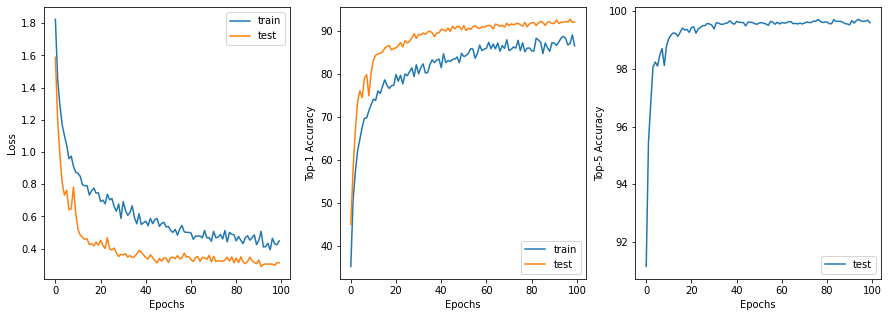

In [21]:
f, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(np.arange(len(history['train']['loss'])), history['train']['loss'])
ax[0].plot(np.arange(len(history['test']['loss'])), history['test']['loss'])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(['train','test'])
ax[1].plot(np.arange(len(history['train']['top1-acc'])), history['train']['top1-acc'])
ax[1].plot(np.arange(len(history['test']['top1-acc'])), history['test']['top1-acc'])
ax[1].set_ylabel('Top-1 Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train','test'])
ax[2].plot(np.arange(len(history['test']['top5-acc'])), history['test']['top5-acc'])
ax[2].set_ylabel('Top-5 Accuracy')
ax[2].set_xlabel('Epochs')
ax[2].legend(['test'])

# Compare to ResNet18 without CutMix

Model | CutMix | Top1-Acc 
---|---|---
ResNet18 | X | 91.54 
ResNet18 | O | 92.67

In [25]:
history_base = json.load(open('ResNet18_epoch100_lr01.json','r'))

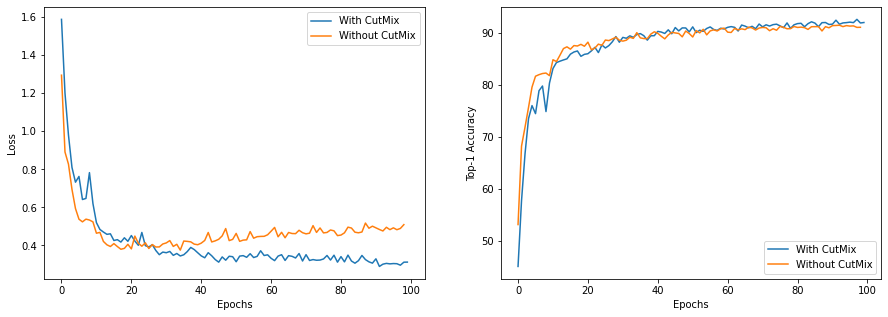

In [36]:
f, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(history['test']['loss'])), history['test']['loss'])
ax[0].plot(np.arange(len(history_base['test']['loss'])), history_base['test']['loss'])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(['With CutMix','Without CutMix'])
ax[1].plot(np.arange(len(history['test']['top1-acc'])), history['test']['top1-acc'])
ax[1].plot(np.arange(len(history_base['test']['top1-acc'])), np.array(history_base['test']['top1-acc'])*100)
ax[1].set_ylabel('Top-1 Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(['With CutMix','Without CutMix'])

Text(0.5, 0, 'Epochs')

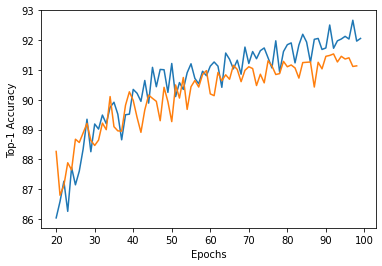

In [41]:
plt.plot(np.arange(20, len(history['test']['top1-acc'])), history['test']['top1-acc'][20:])
plt.plot(np.arange(20, len(history_base['test']['top1-acc'])), np.array(history_base['test']['top1-acc'][20:])*100)
plt.ylabel('Top-1 Accuracy')
plt.xlabel('Epochs')